In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation
from scipy.ndimage.filters import gaussian_filter

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor


## Map utils

In [4]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111



## Entreno el modelo que vamos a usar para predecir

In [5]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [6]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [7]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

In [8]:
random_predictor = RandomPredictor()
random_predictor.fit(regre_data, regre_target)

## Levanto el archivo con las emisiones de los pajaros

In [10]:
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

In [8]:
def get_bird_predictions(all_birds_recep, bird_tag_id, start_time='2018-01-11 10:00:00', end_time='2018-01-11 18:00:00'):
    single_bird = all_birds_recep.filter(lambda x: x['tag_id'] == bird_tag_id).filter(lambda x: start_time <= x['timestamp'] <= end_time)
    birds_data = pd.DataFrame(single_bird.collect()).drop(columns=[4,5])
    predicted = predictor.predict(birds_data)
    predicted = pd.concat([pd.DataFrame(predicted), pd.DataFrame(single_bird.collect())], axis=1).values
    return predicted
    

In [9]:
#smoother = Smoother(window_threshold=300)
#smooth_predictions_np = smoother.smooth_predictions(predictions)
#smooth_predictions_np = smoother.filter_predictions(predictions)

In [13]:
def update_animation(data, p):
    x = data[0]
    y = data[1]
    p.set_data(x, y)
    plt.title(data[7])
    return p
 
    
def show_heatmap(bird_predictions, bird_id):
    DELAY = 200

    fig, ax = plt.subplots()
    point, = ax.plot([0], [0], 'go', color='red')
    point.set_data(0, 0)
    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)
    all_points_pos = pd.DataFrame(data.map(lambda p: {'x': p['x'], 'y': p['y']}).collect())
    plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
    for antenna in np.arange(4):
            pos_antena = posicion_antenas[antenna]
            plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
            name = nombre_antenas[antenna]
            ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 

    range = np.array([[0,x_f-x_0],[0,y_f-y_0]])
    heatmap, xedges, yedges = np.histogram2d(bird_predictions[:,1], bird_predictions[:,0], bins=(64,64), range=range)
    extent = [0, x_f-x_0, 0, y_f-y_0]
    plt.imshow(heatmap, extent=extent, origin='lower', cmap=None)
    #plt.imshow(gaussian_filter(heatmap, sigma=2, mode='nearest'), extent=extent, origin='lower', cmap=None)
    plt.title('Bird {}'.format(bird_id))
    #ani = animation.FuncAnimation(fig, update_animation, bird_predictions, interval=DELAY, fargs=(point,), repeat=False)
        

<IPython.core.display.Javascript object>


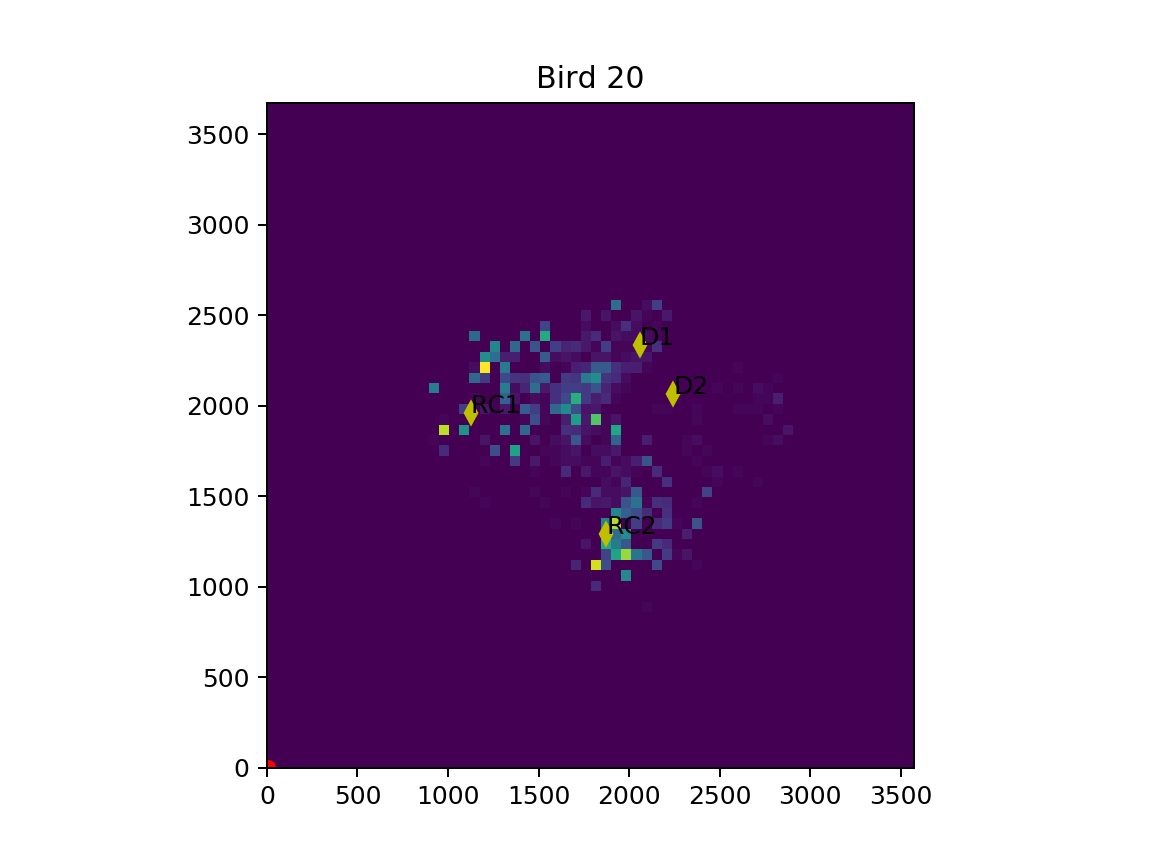

In [14]:
predictions = get_bird_predictions(birds_recep, 20)
show_heatmap(predictions, 20)

<IPython.core.display.Javascript object>


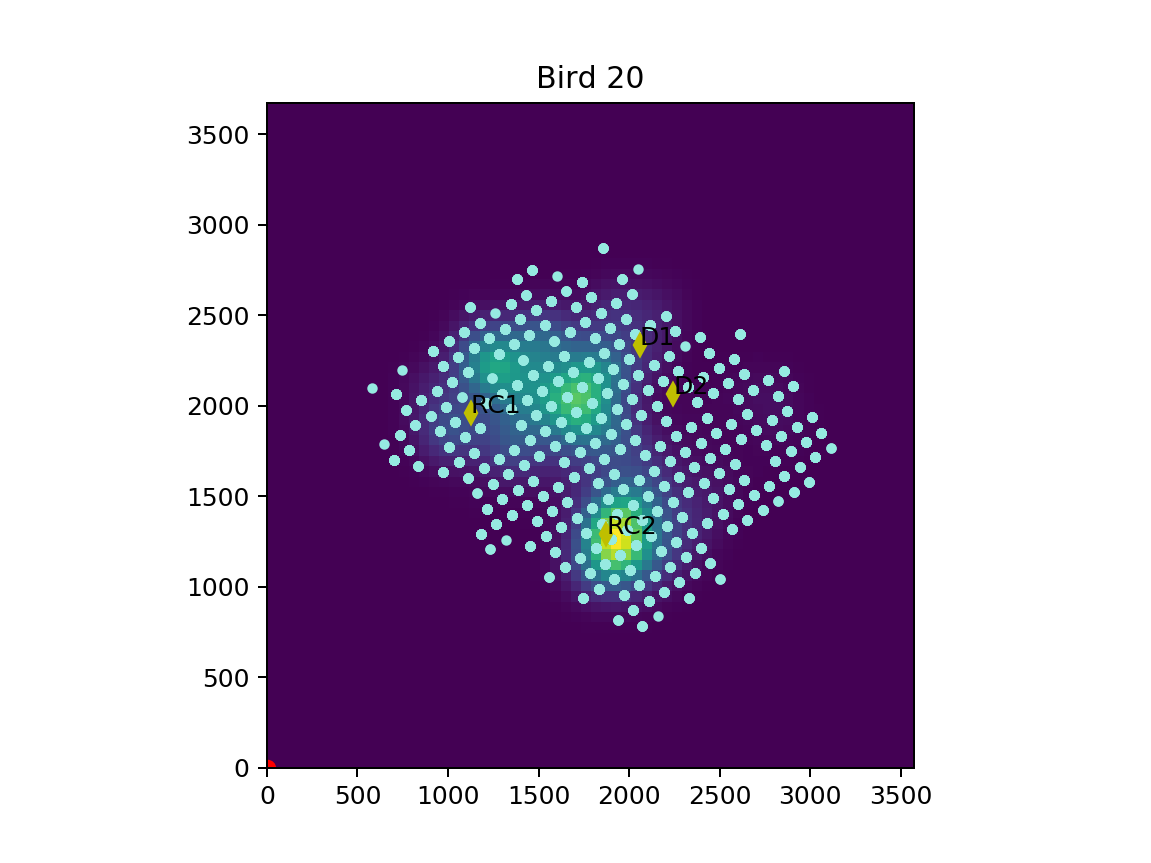

In [40]:
predictions = get_bird_predictions(birds_recep, 20)
show_heatmap(predictions, 20)

<IPython.core.display.Javascript object>


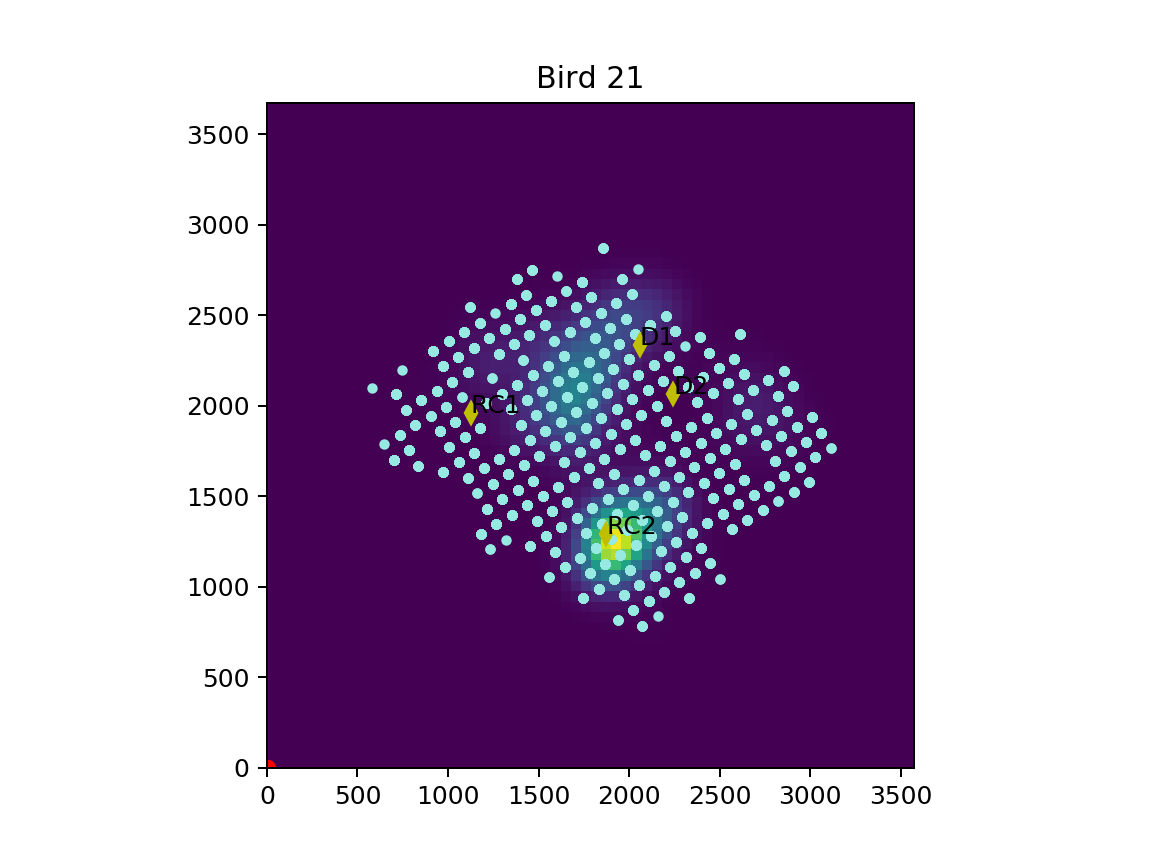

In [41]:
predictions = get_bird_predictions(birds_recep, 21)
show_heatmap(predictions, 21)

<IPython.core.display.Javascript object>


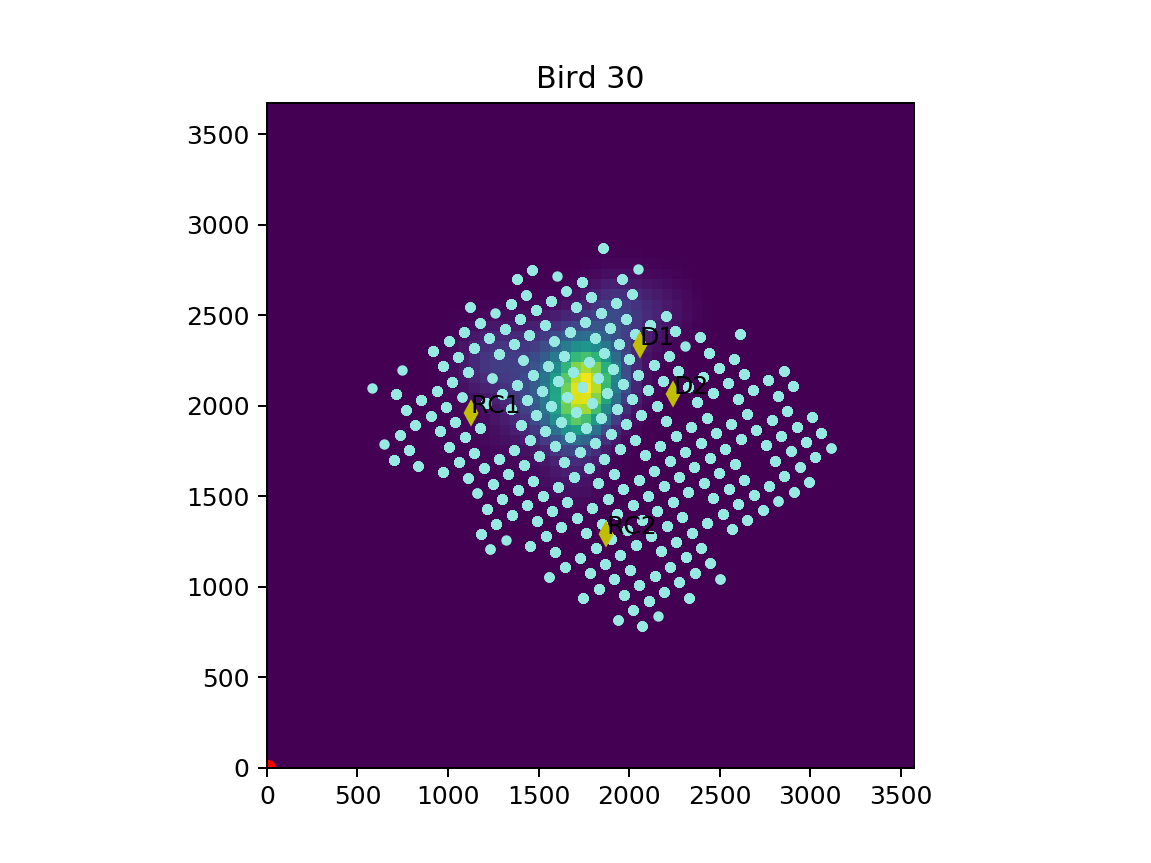

In [42]:
predictions = get_bird_predictions(birds_recep, 30)
show_heatmap(predictions, 30)

<IPython.core.display.Javascript object>


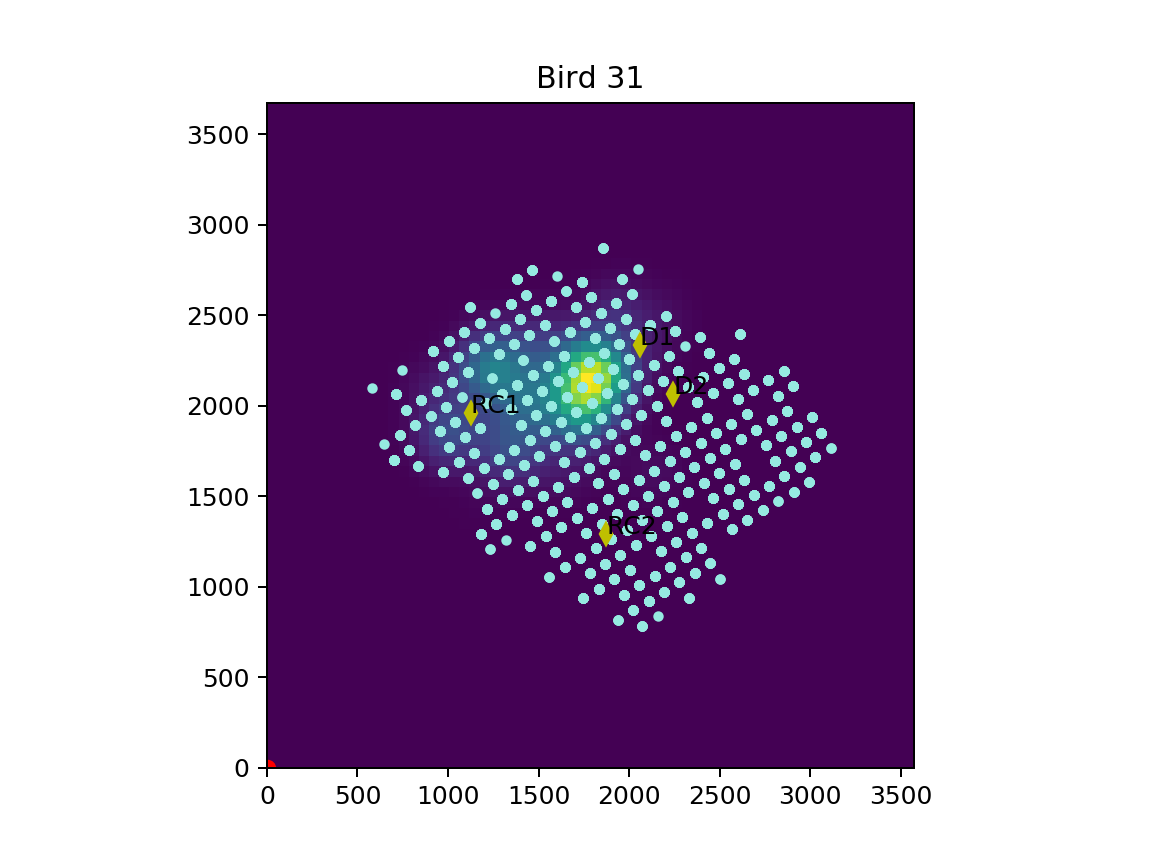

In [43]:
predictions = get_bird_predictions(birds_recep, 31)
show_heatmap(predictions, 31)

<IPython.core.display.Javascript object>


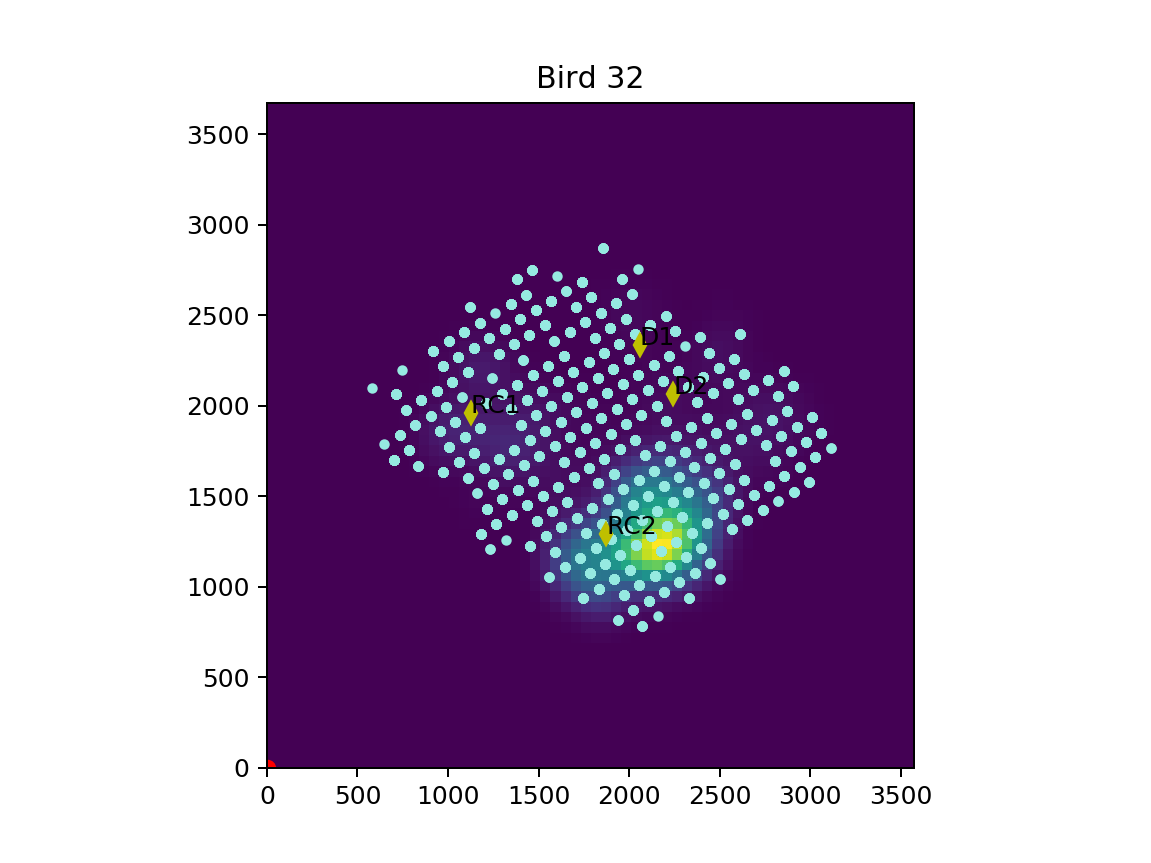

In [45]:
predictions = get_bird_predictions(birds_recep, 32)
show_heatmap(predictions, 32)

<IPython.core.display.Javascript object>


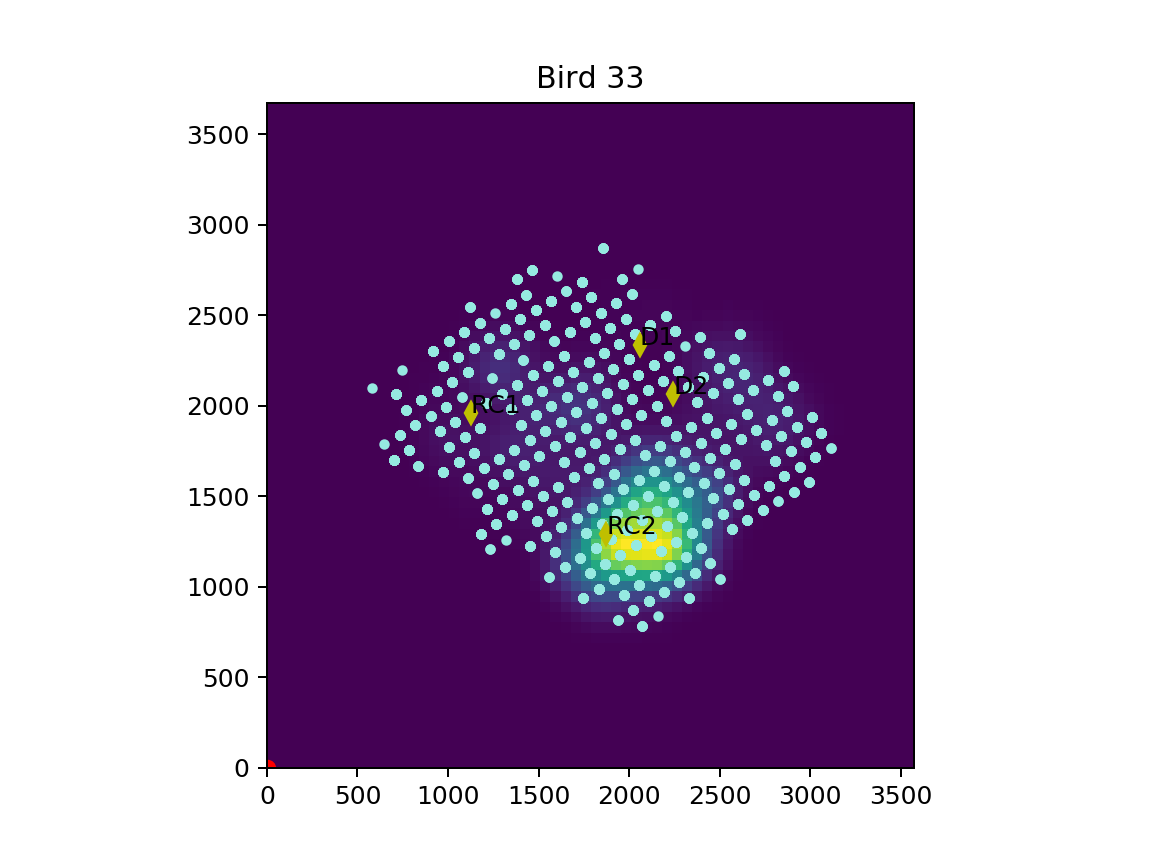

In [44]:
predictions = get_bird_predictions(birds_recep, 33)
show_heatmap(predictions, 33)

<IPython.core.display.Javascript object>


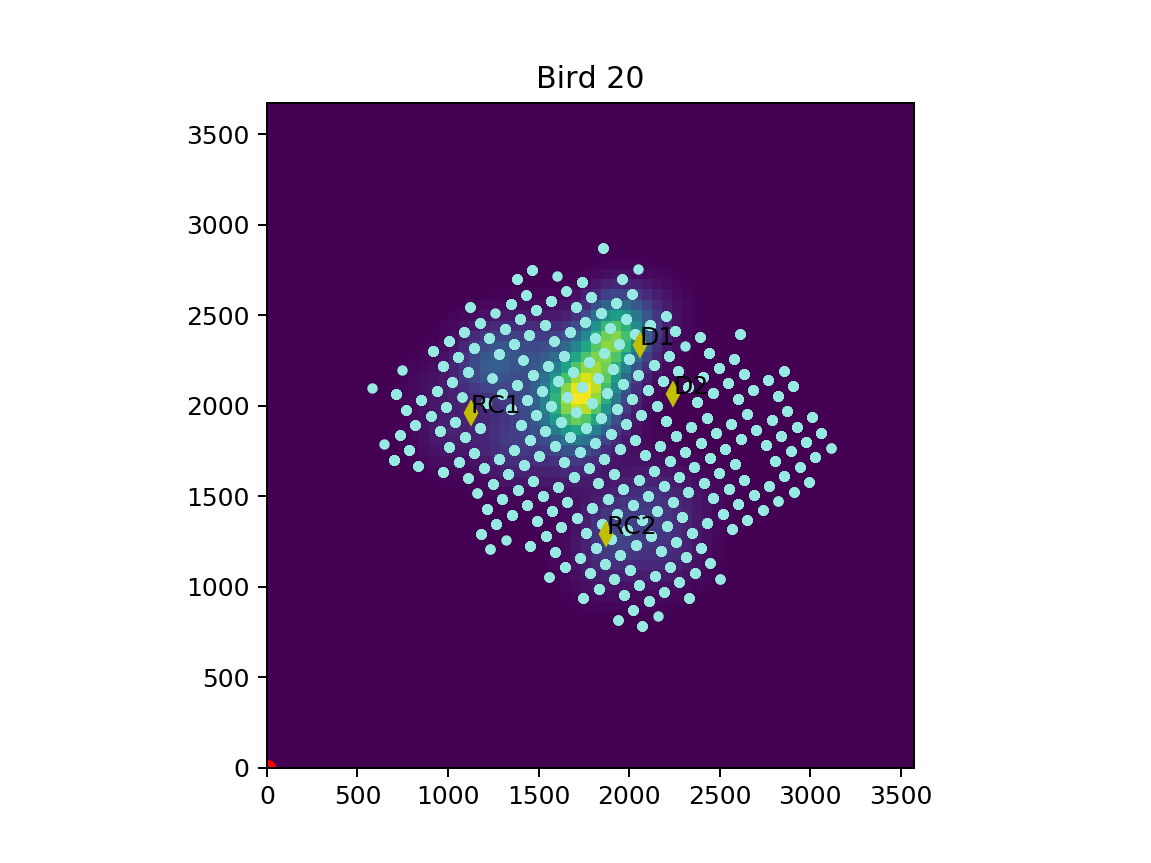

In [13]:
predictions = get_bird_predictions(birds_recep, 20,  start_time='2018-01-12 10:00:00', end_time='2018-01-12 18:00:00')
show_heatmap(predictions, 20)

<IPython.core.display.Javascript object>


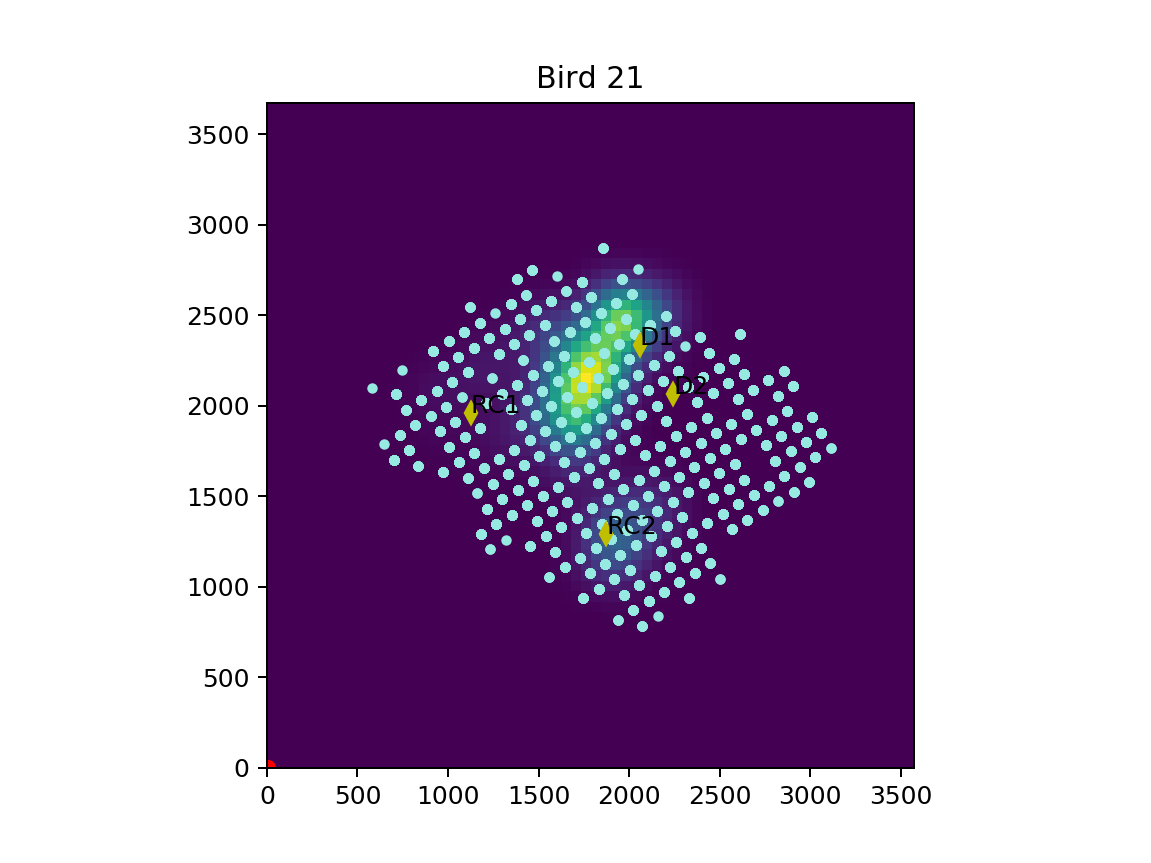

In [14]:
predictions = get_bird_predictions(birds_recep, 21,  start_time='2018-01-12 10:00:00', end_time='2018-01-12 18:00:00')
show_heatmap(predictions, 21)

<IPython.core.display.Javascript object>


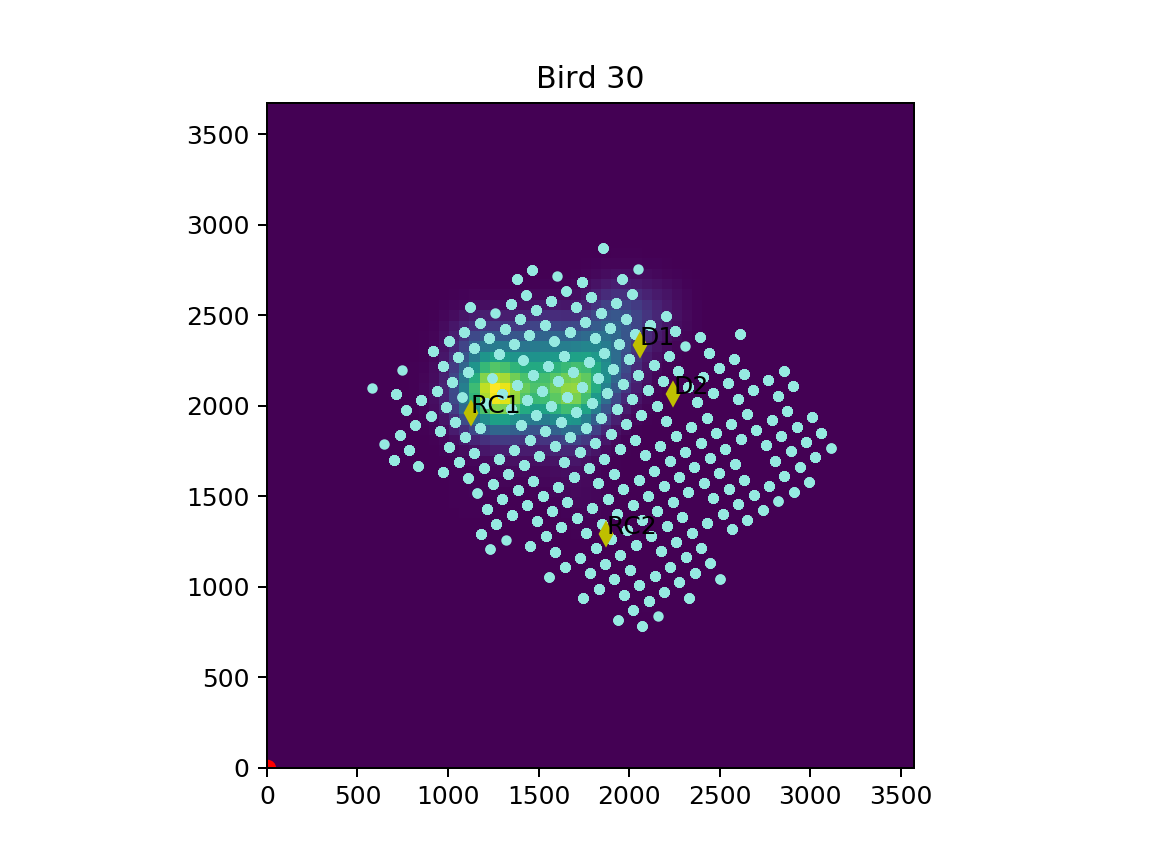

In [15]:
predictions = get_bird_predictions(birds_recep, 30,  start_time='2018-01-12 10:00:00', end_time='2018-01-12 18:00:00')
show_heatmap(predictions, 30)

<IPython.core.display.Javascript object>


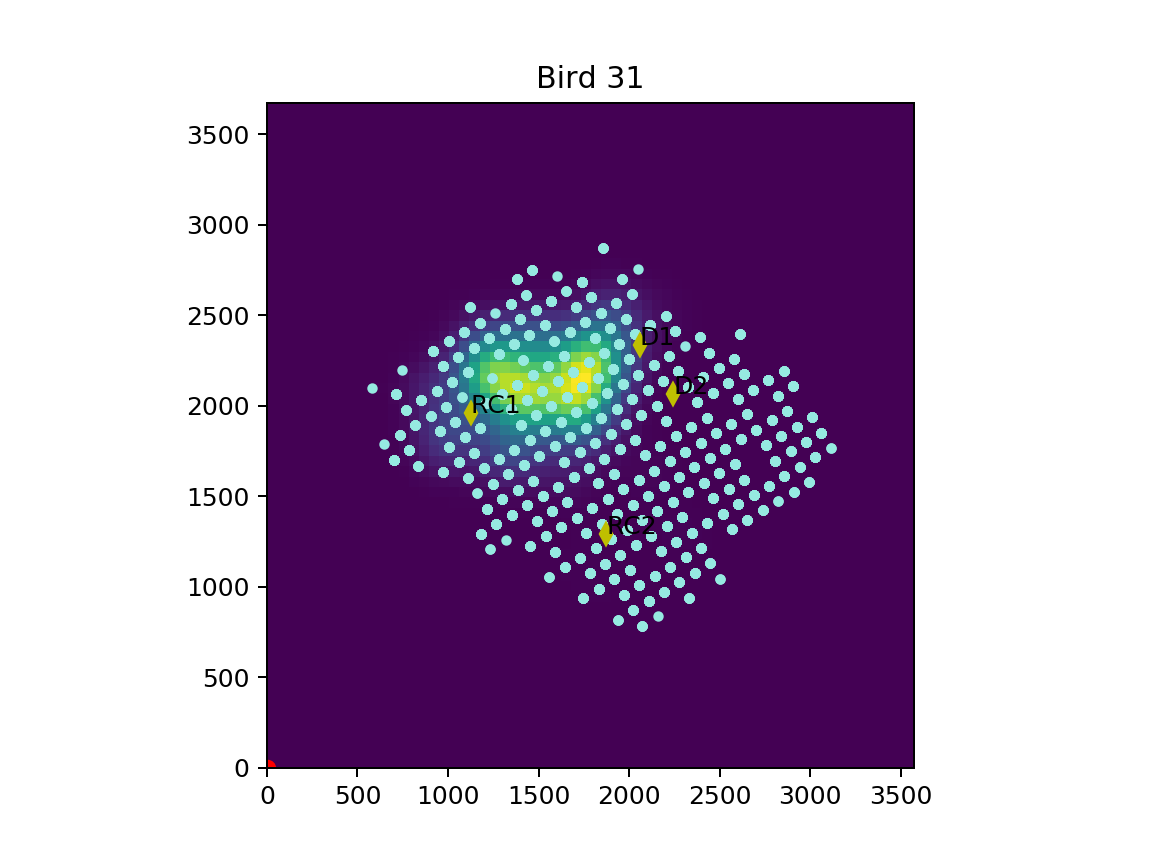

In [16]:
predictions = get_bird_predictions(birds_recep, 31,  start_time='2018-01-12 10:00:00', end_time='2018-01-12 18:00:00')
show_heatmap(predictions, 31)

<IPython.core.display.Javascript object>


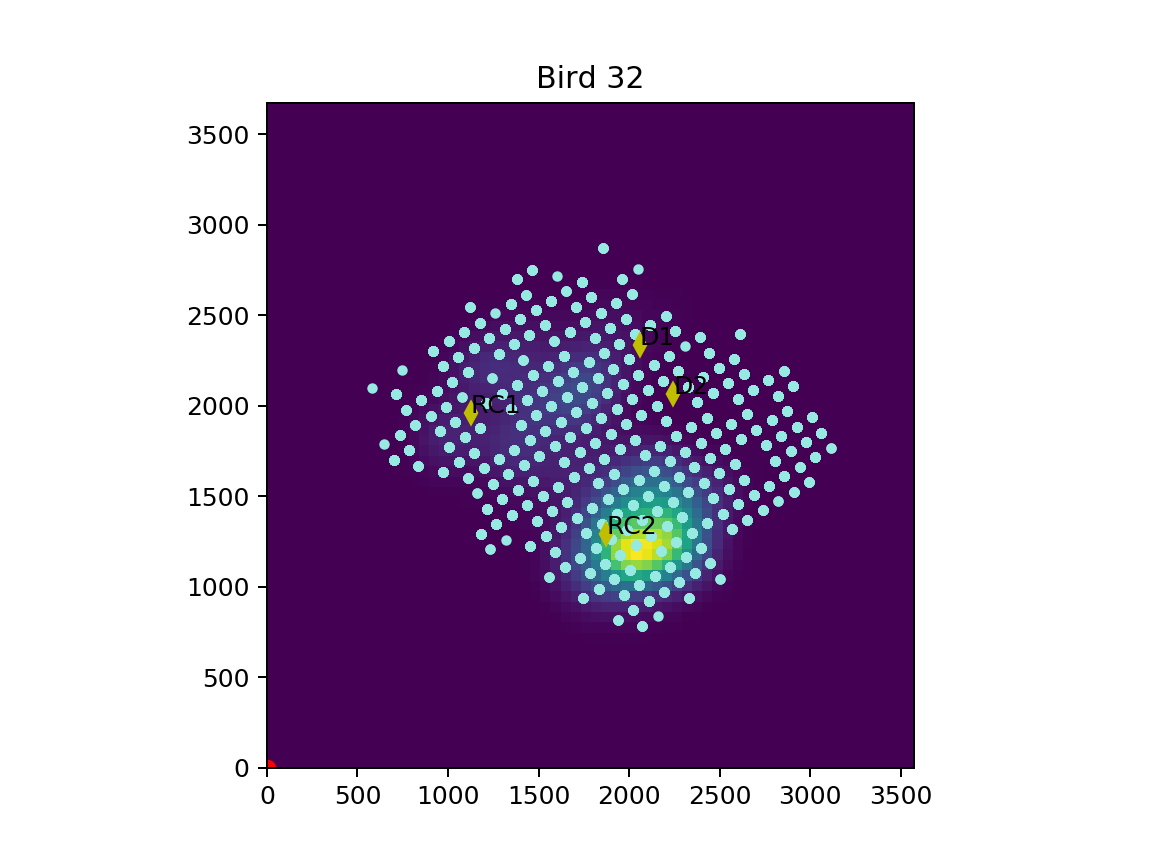

In [30]:
predictions = get_bird_predictions(birds_recep, 32,  start_time='2018-01-12 10:00:00', end_time='2018-01-12 18:00:00')
show_heatmap(predictions, 32)

<IPython.core.display.Javascript object>


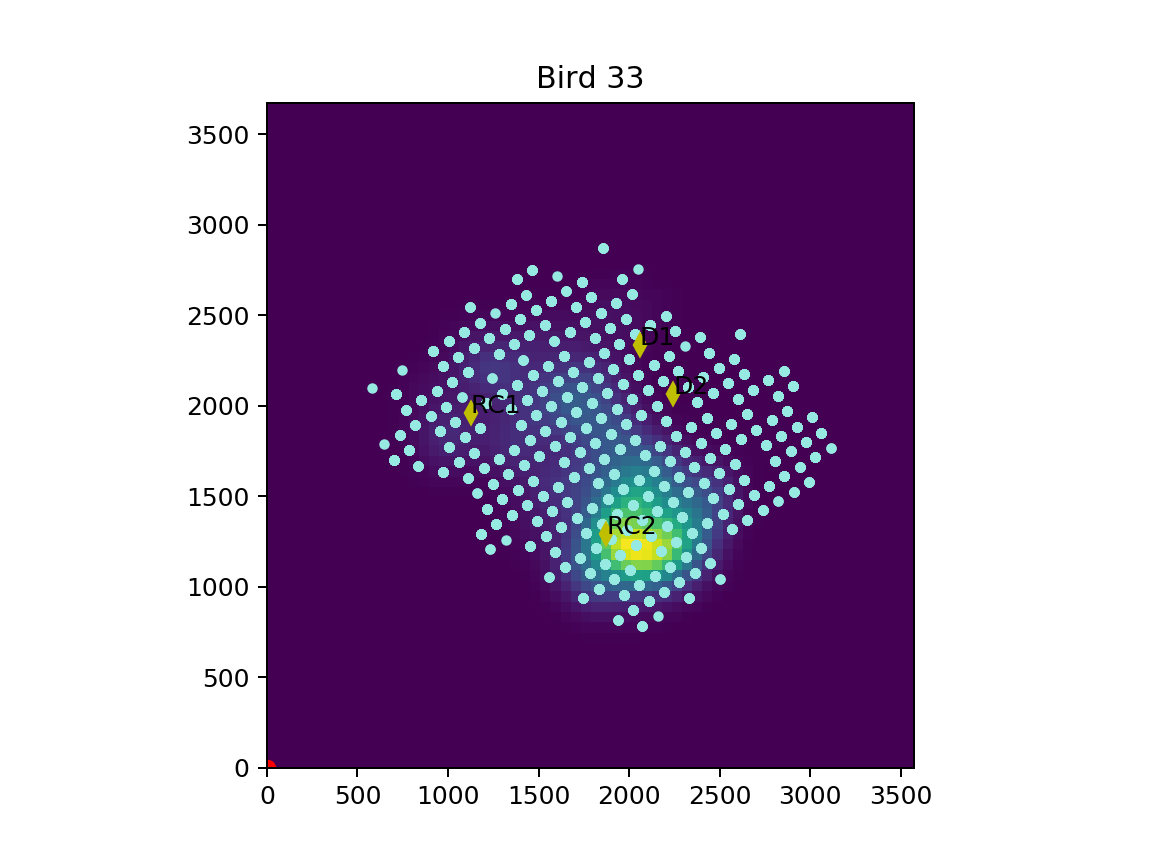

In [29]:
predictions = get_bird_predictions(birds_recep, 33,  start_time='2018-01-12 10:00:00', end_time='2018-01-12 18:00:00')
show_heatmap(predictions, 33)

<IPython.core.display.Javascript object>


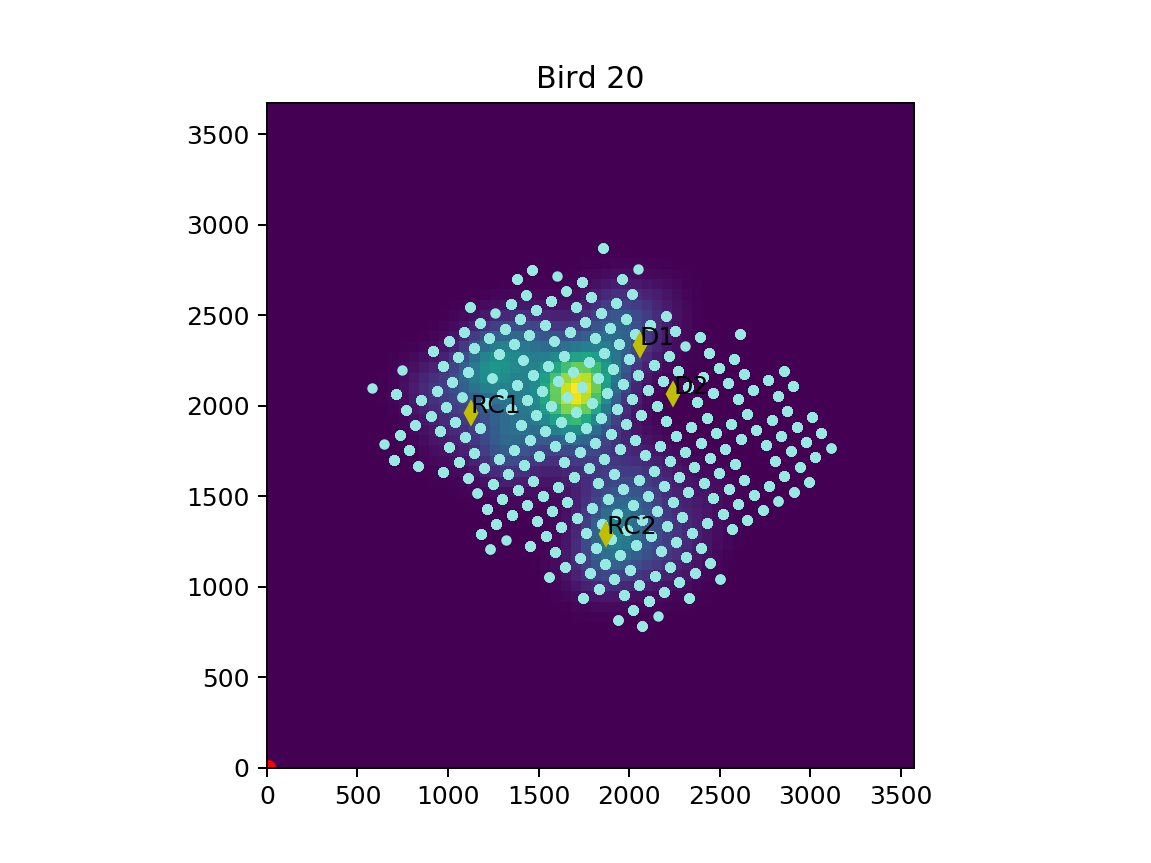

In [55]:
predictions = get_bird_predictions(birds_recep, 20,  start_time='2018-01-13 10:00:00', end_time='2018-01-13 18:00:00')
show_heatmap(predictions, 20)

<IPython.core.display.Javascript object>


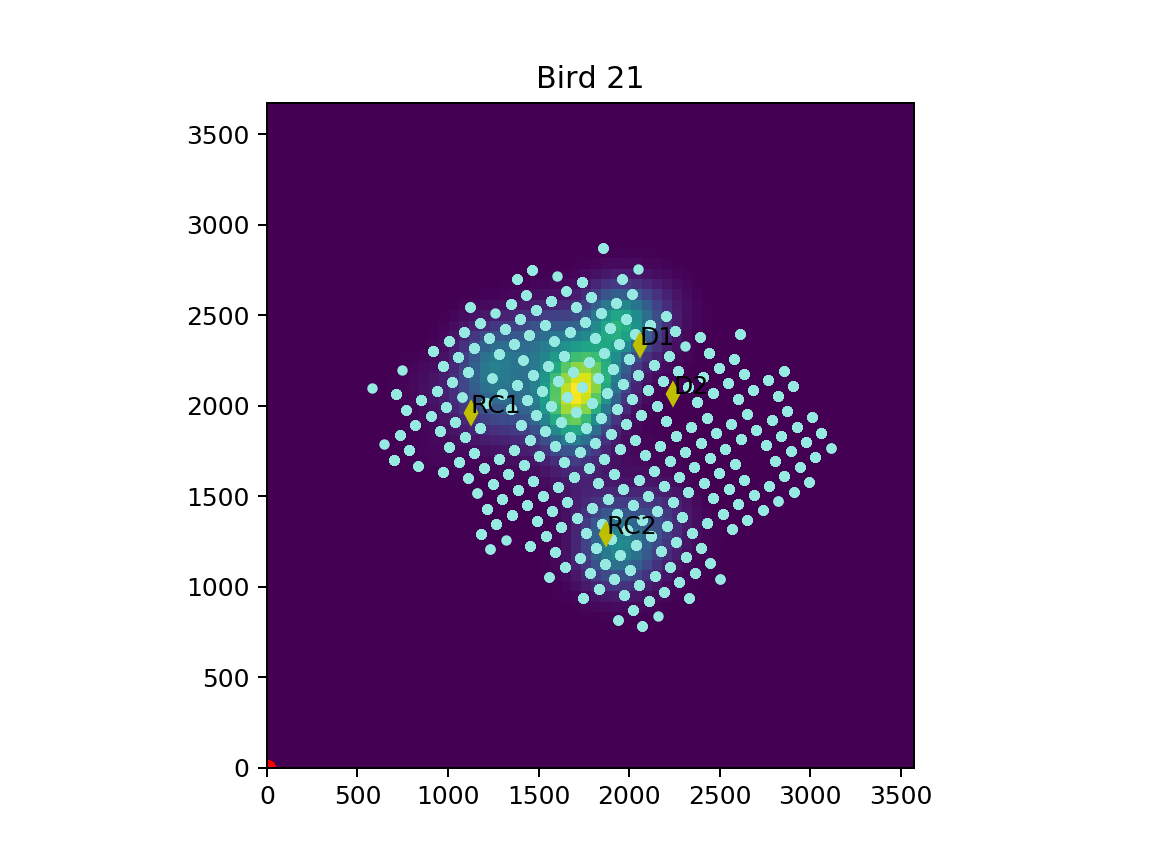

In [56]:
predictions = get_bird_predictions(birds_recep, 21,  start_time='2018-01-13 10:00:00', end_time='2018-01-13 18:00:00')
show_heatmap(predictions, 21)

<IPython.core.display.Javascript object>


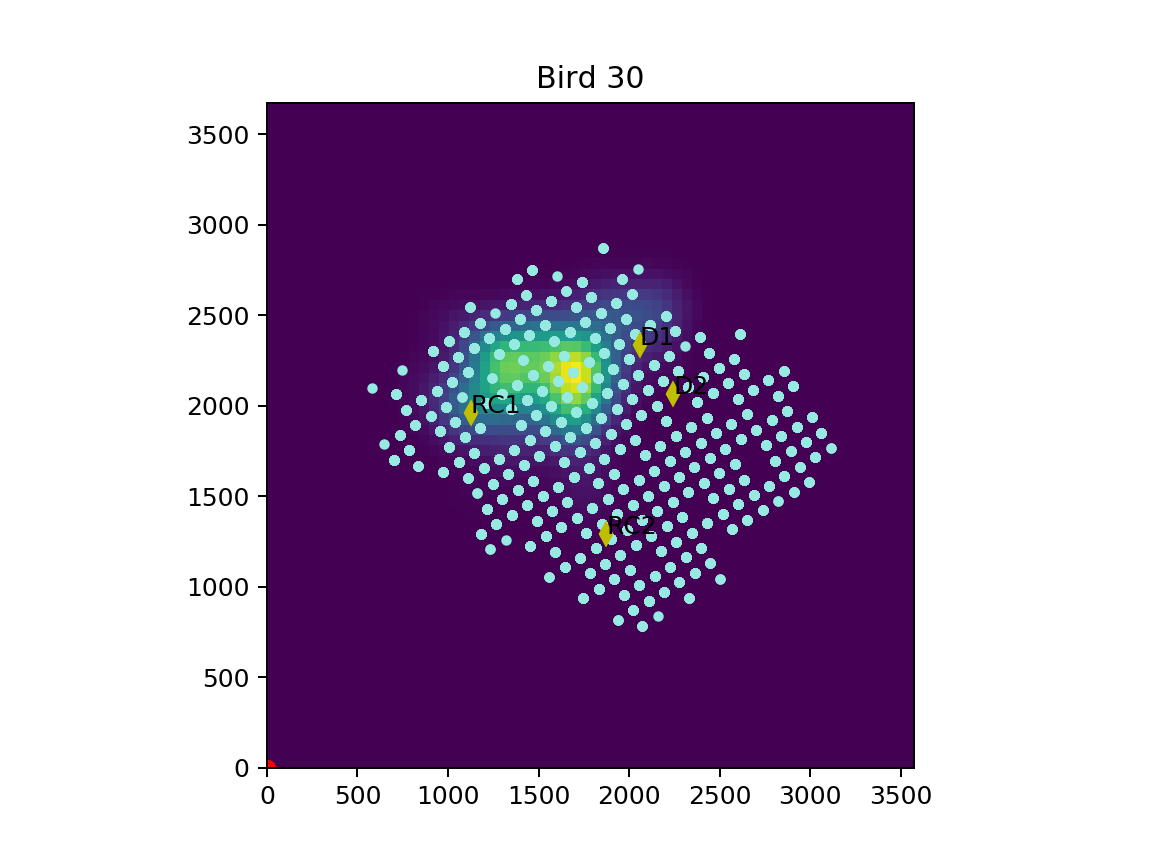

In [57]:
predictions = get_bird_predictions(birds_recep, 30,  start_time='2018-01-13 10:00:00', end_time='2018-01-13 18:00:00')
show_heatmap(predictions, 30)

<IPython.core.display.Javascript object>


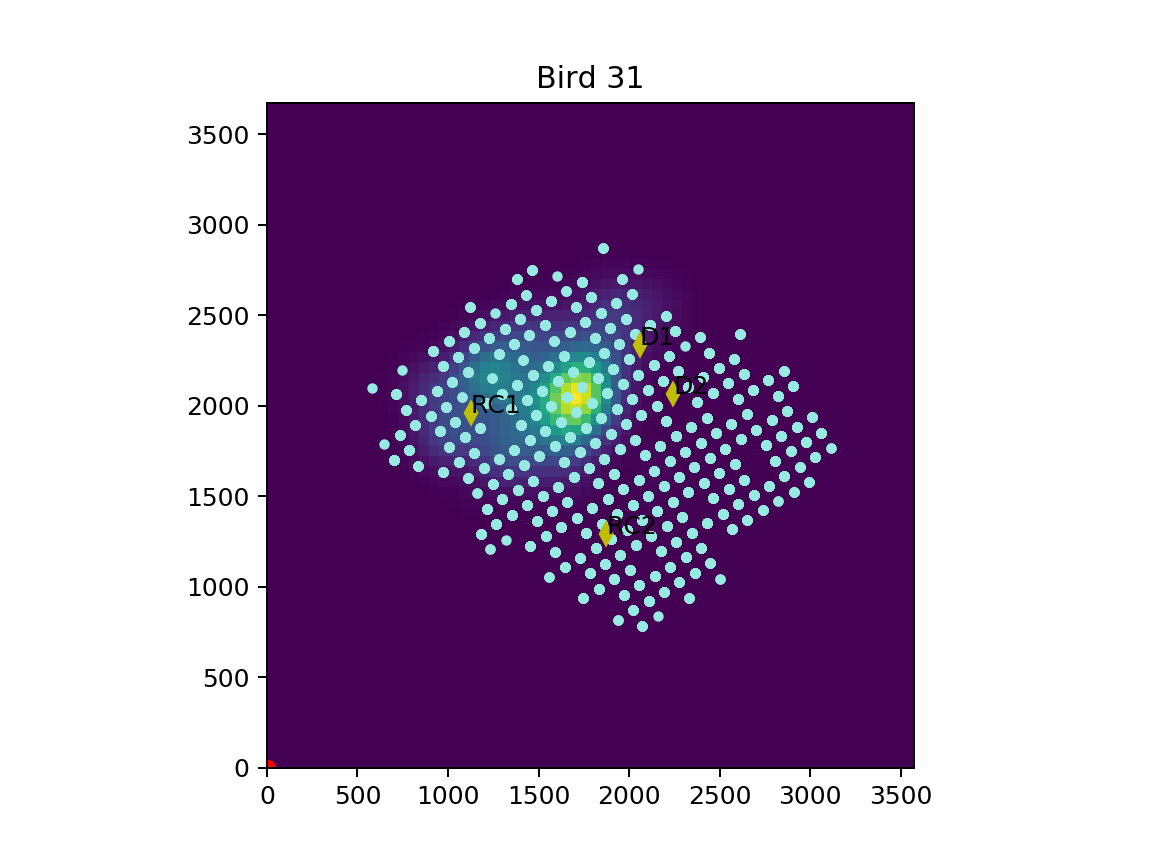

In [58]:
predictions = get_bird_predictions(birds_recep, 31,  start_time='2018-01-13 10:00:00', end_time='2018-01-13 18:00:00')
show_heatmap(predictions, 31)

<IPython.core.display.Javascript object>


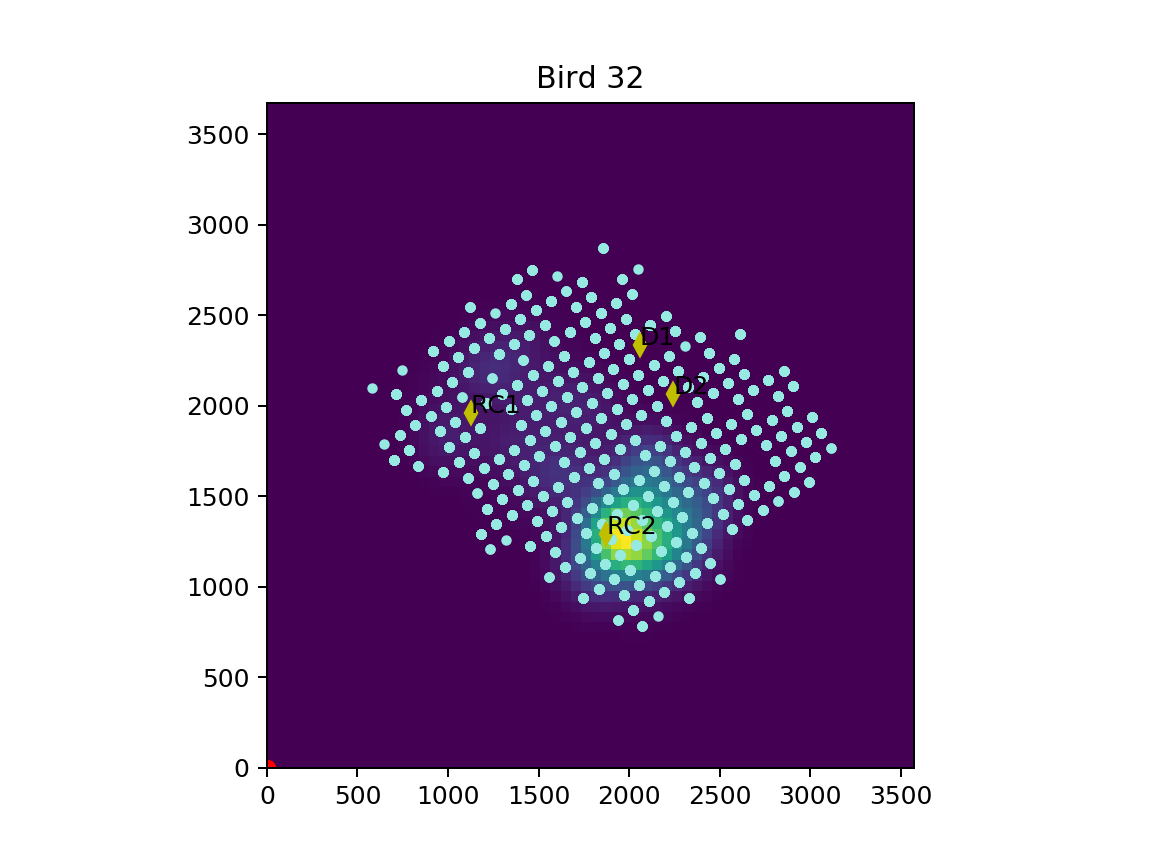

In [59]:
predictions = get_bird_predictions(birds_recep, 32,  start_time='2018-01-13 10:00:00', end_time='2018-01-13 18:00:00')
show_heatmap(predictions, 32)

<IPython.core.display.Javascript object>


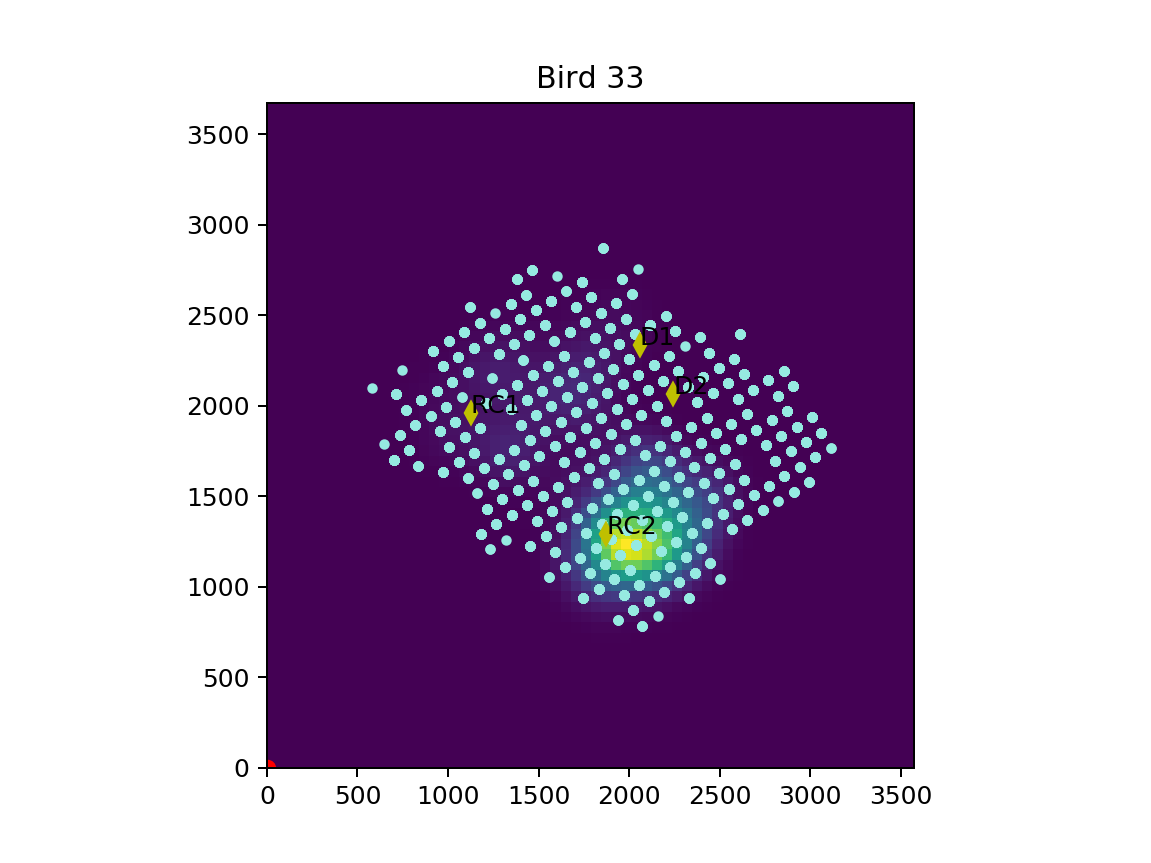

In [60]:
predictions = get_bird_predictions(birds_recep, 33,  start_time='2018-01-13 10:00:00', end_time='2018-01-13 18:00:00')
show_heatmap(predictions, 33)

<IPython.core.display.Javascript object>


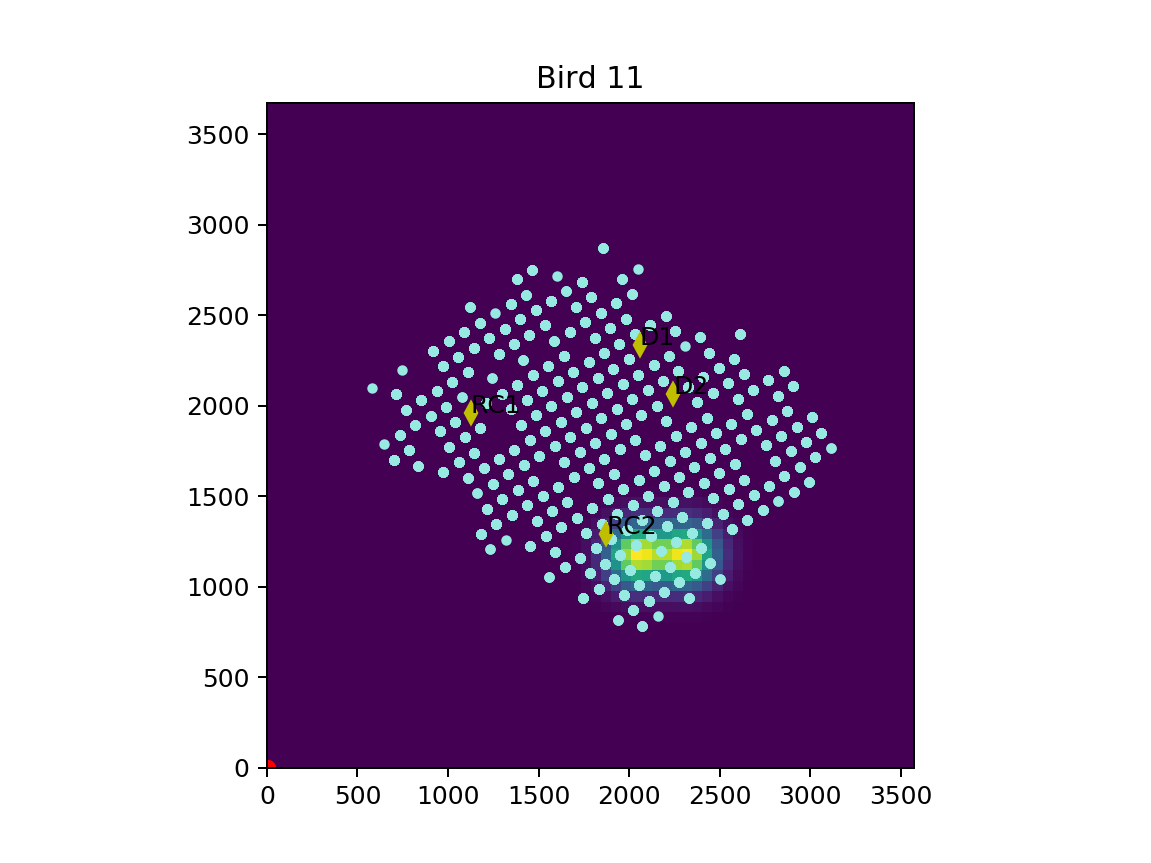

In [68]:
predictions = get_bird_predictions(birds_recep, 11,  start_time='2018-01-13 10:00:00', end_time='2018-01-13 18:00:00')
show_heatmap(predictions, 11)

### Algunos pajaros parecen no dormir mucho....

2 1492


<IPython.core.display.Javascript object>


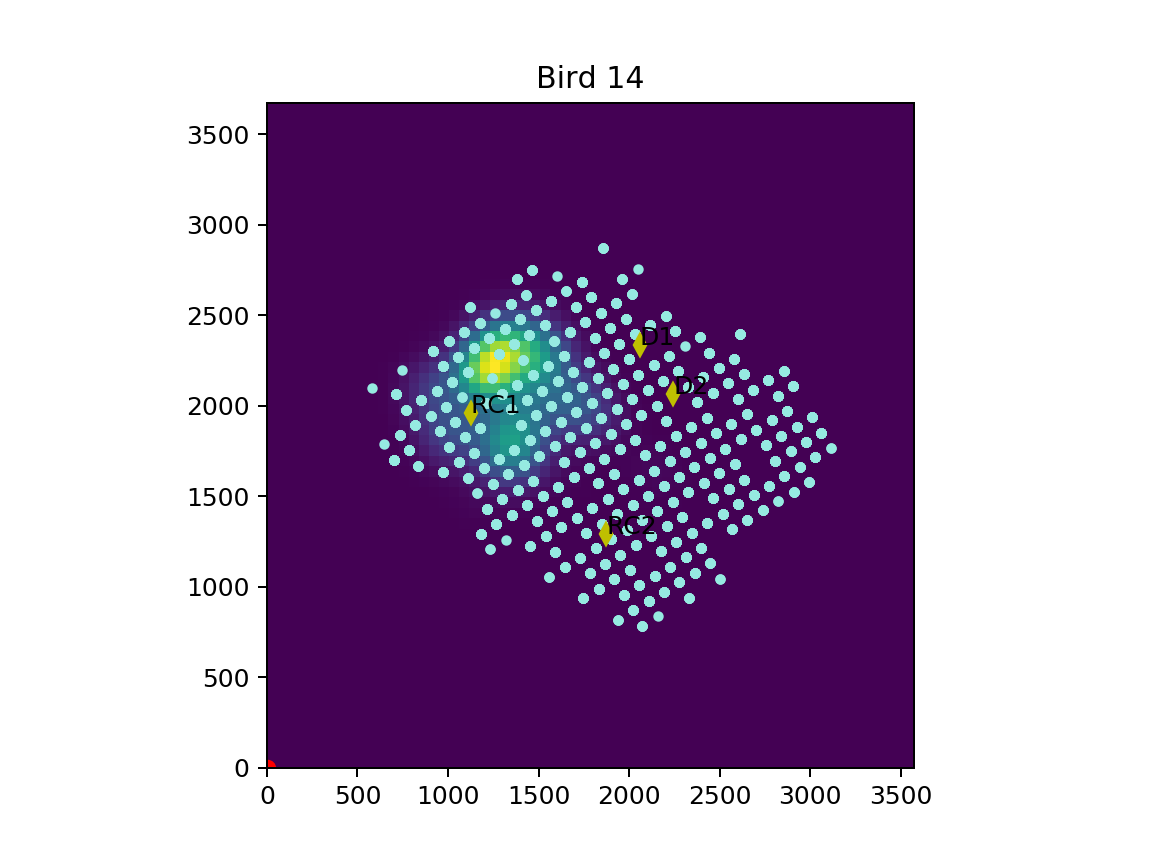

3 3833


<IPython.core.display.Javascript object>


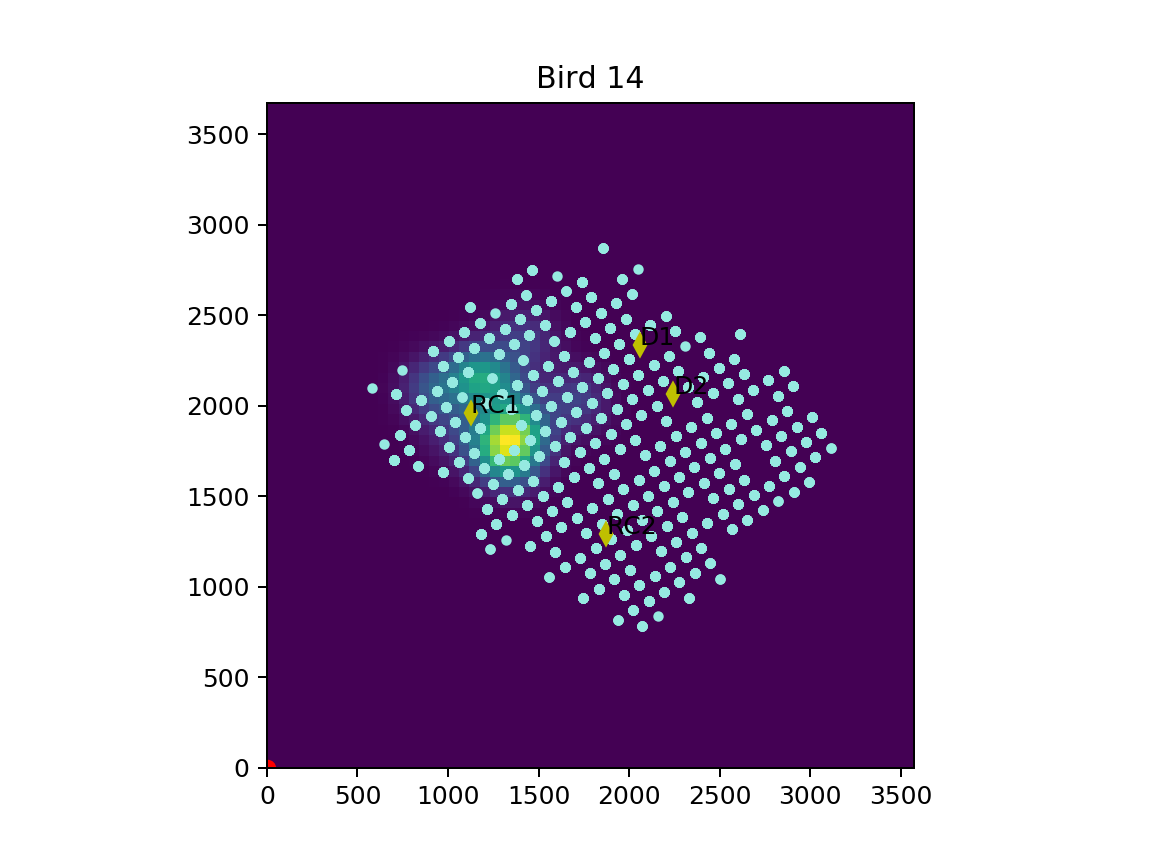

4 3811


<IPython.core.display.Javascript object>


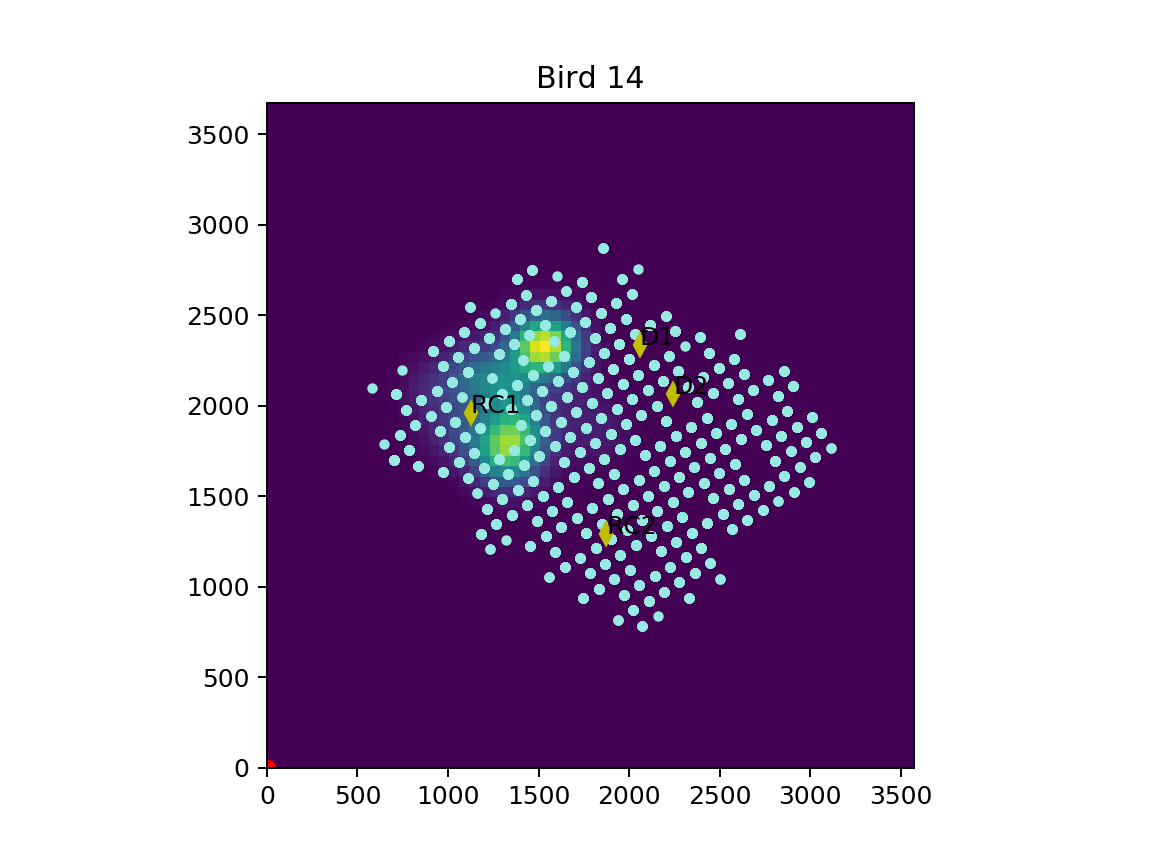

5 4143


<IPython.core.display.Javascript object>


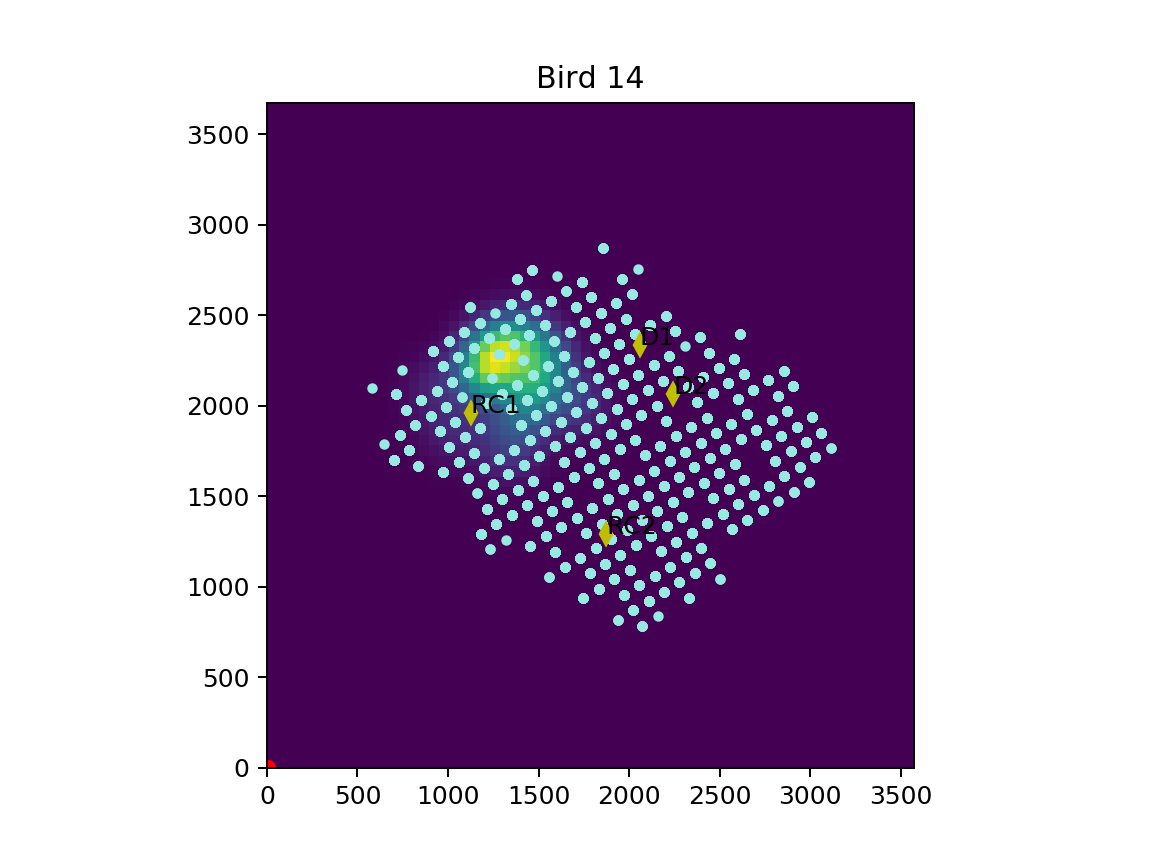

In [15]:
for i in np.arange(6):
    try:
        predictions = get_bird_predictions(birds_recep, 14,  start_time='2018-01-{} 22:00:00'.format(11+i), end_time='2018-01-{} 04:00:00'.format(11+i+1))
        print(i, len(predictions))
        show_heatmap(predictions, 14)
    except:
        pass
        
        

1 3852


<IPython.core.display.Javascript object>


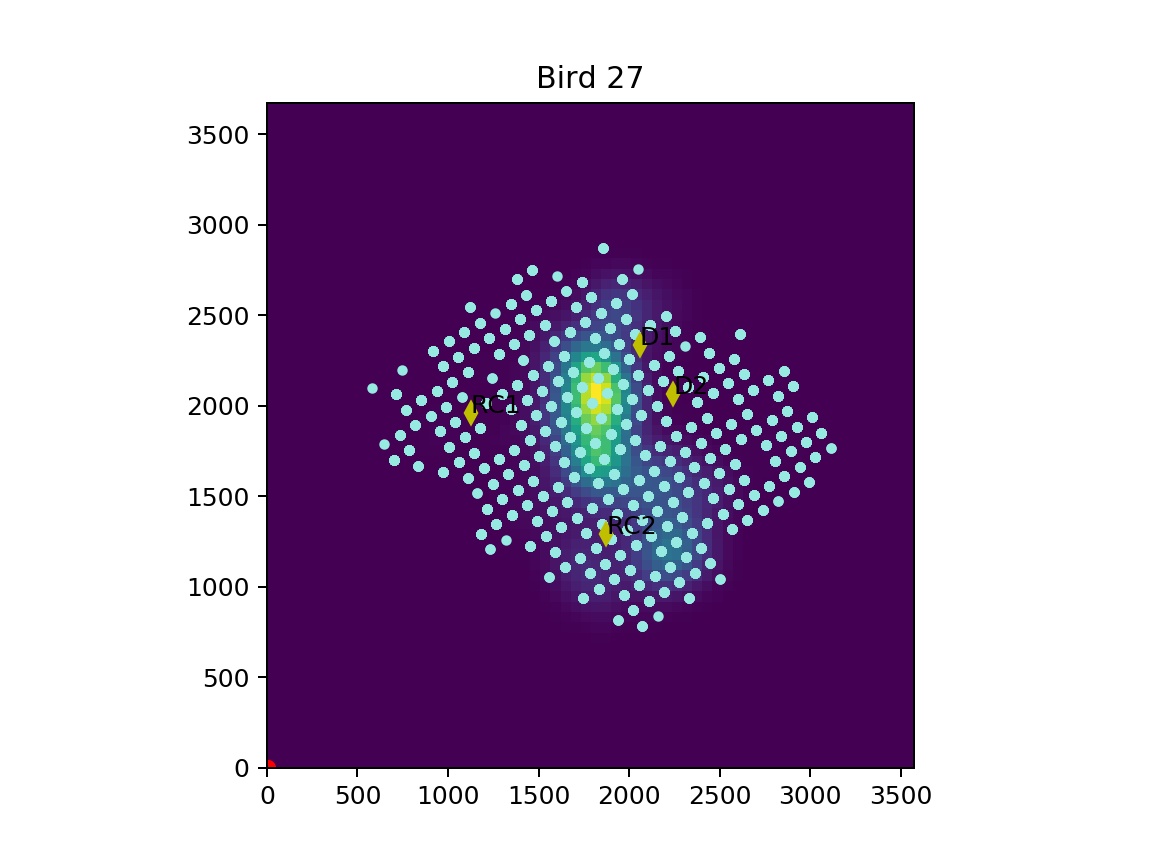

2 3840


<IPython.core.display.Javascript object>


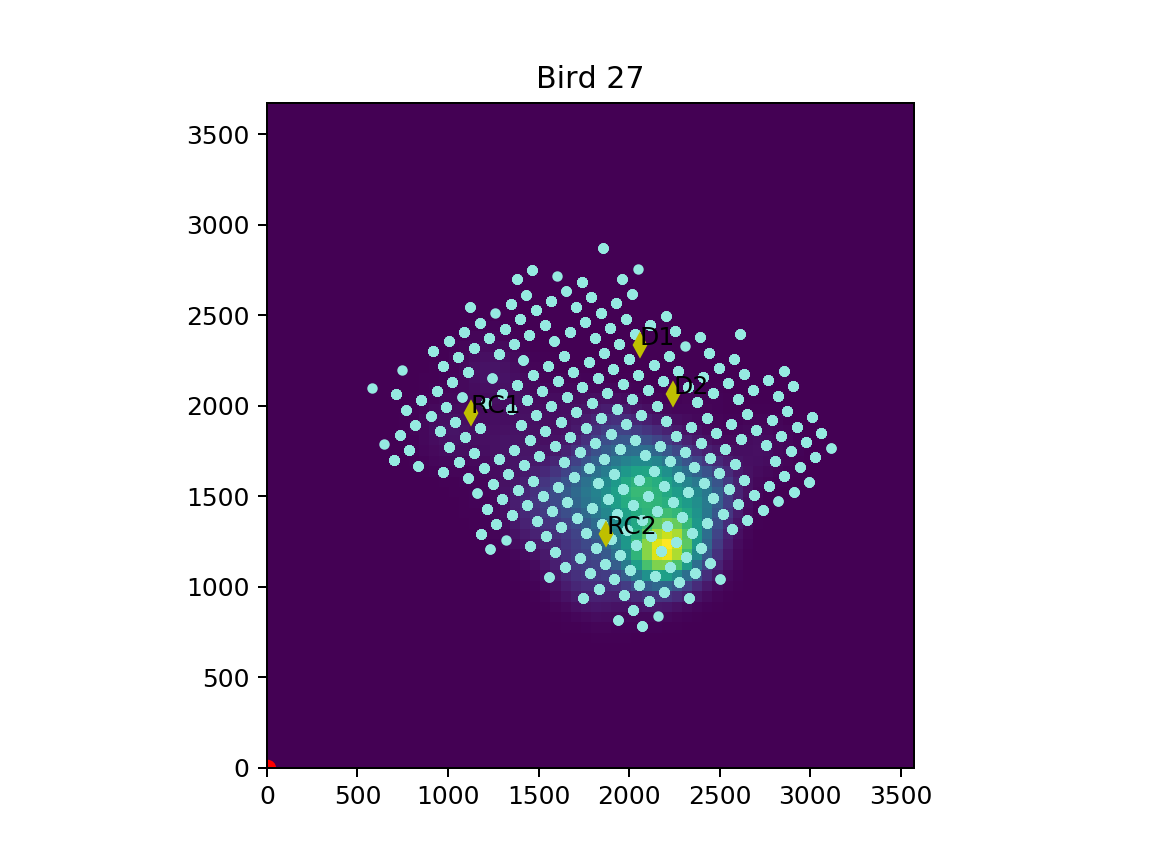

3 3796


<IPython.core.display.Javascript object>


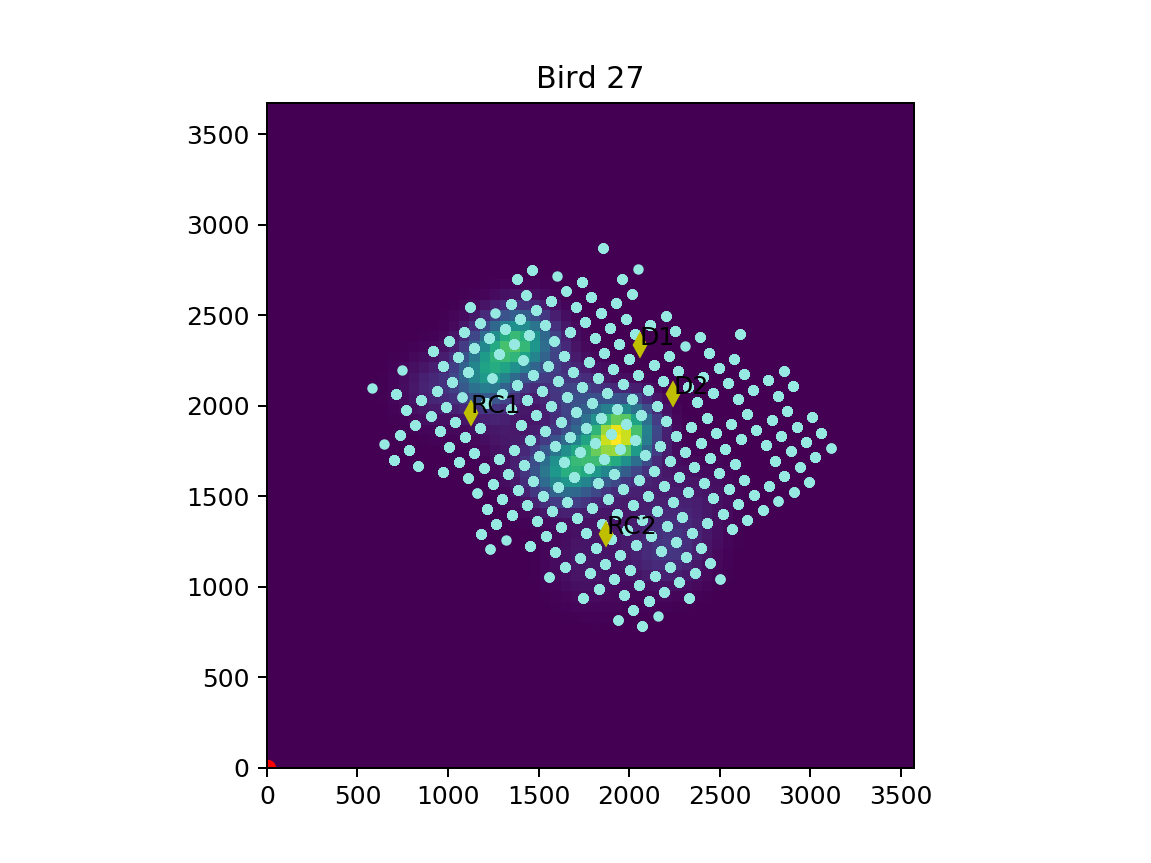

4 3166


<IPython.core.display.Javascript object>


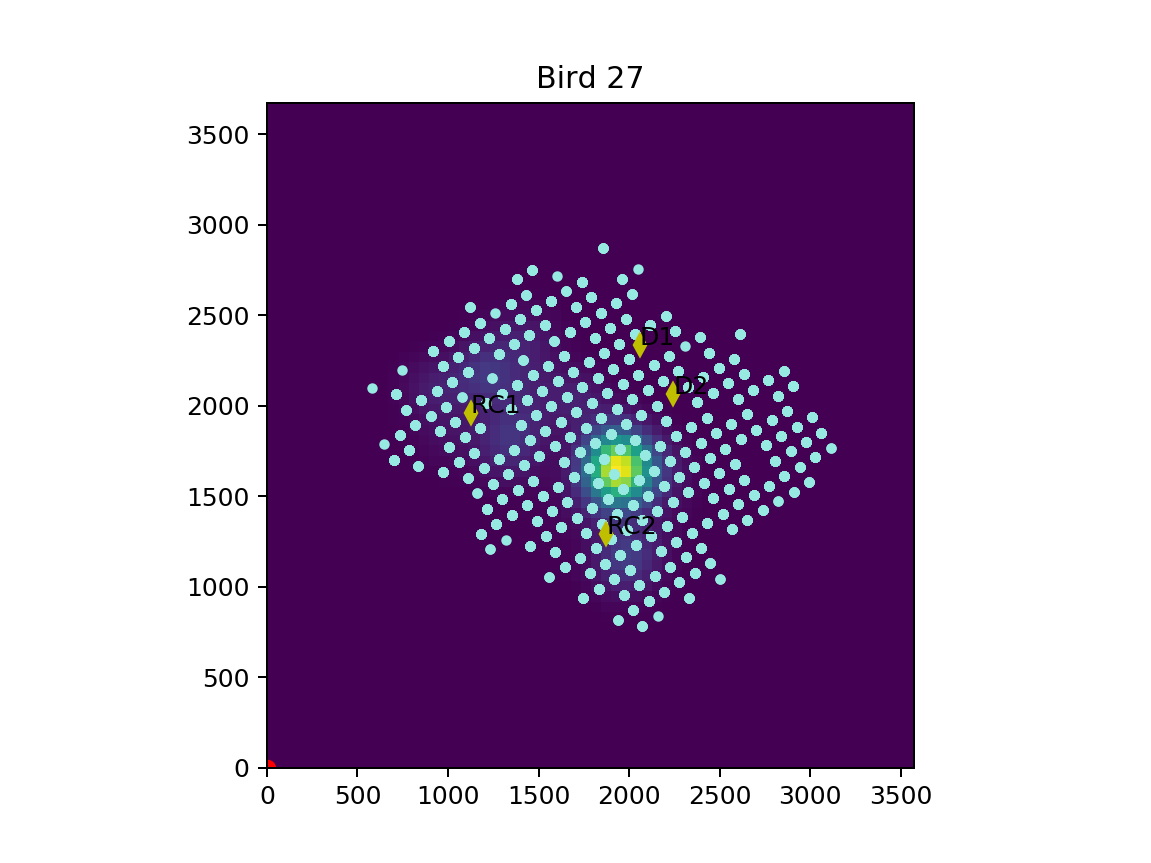

5 811


<IPython.core.display.Javascript object>


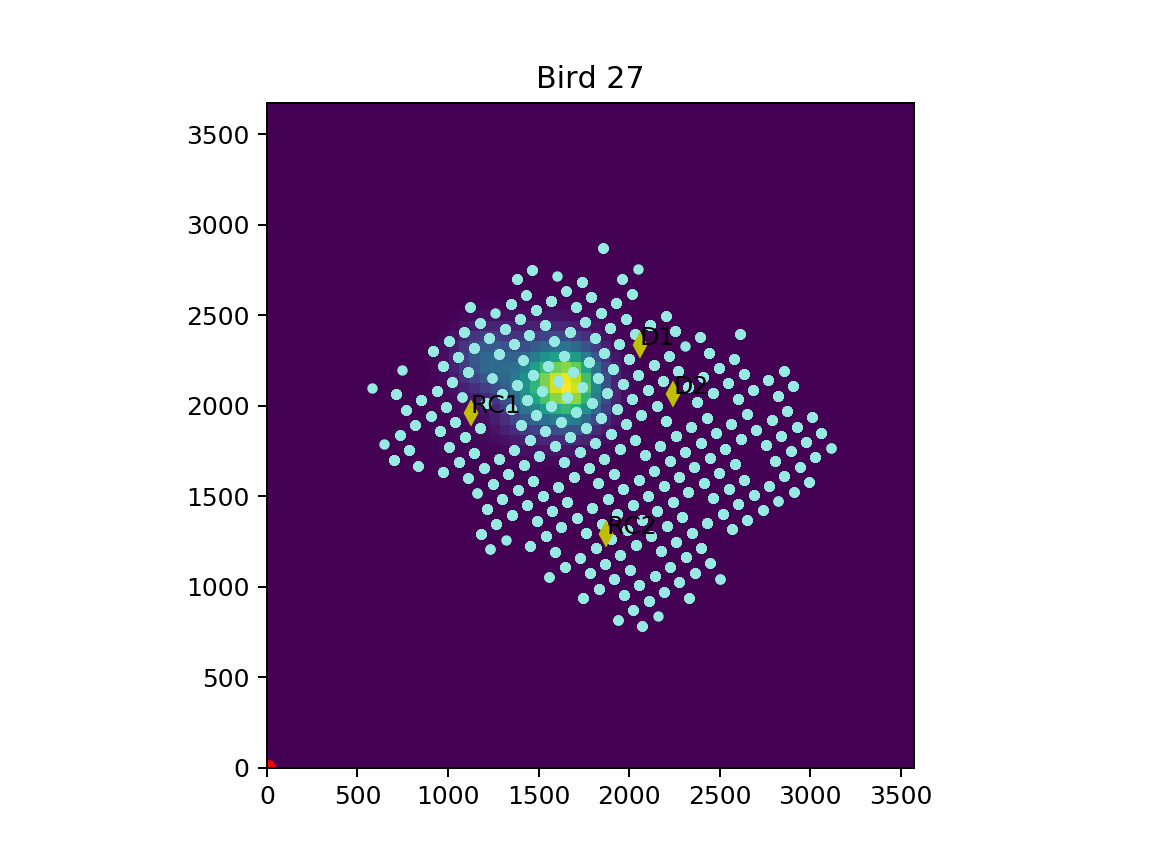

In [17]:
for i in np.arange(6):
    try:
        predictions = get_bird_predictions(birds_recep, 27,  start_time='2018-01-{} 22:00:00'.format(11+i), end_time='2018-01-{} 04:00:00'.format(11+i+1))
        print(i, len(predictions))
        show_heatmap(predictions, 27)
    except:
        pass
        
        

### Donde suele caer nuestras predicciones?

In [21]:
birds_data = birds_recep.toDF().toPandas().drop(columns=['tag_id','timestamp'])
predicted = predictor.predict(birds_data)
predicted = pd.concat([pd.DataFrame(predicted), birds_data], axis=1).values

NameError: name 'single_bird' is not defined

In [88]:
range = np.array([[0,x_f-x_0],[0,y_f-y_0]])
heatmap, xedges, yedges = np.histogram2d(predicted[:,1], predicted[:,0], bins=(64,64), range=range)
extent = [0, x_f-x_0, 0, y_f-y_0]

<IPython.core.display.Javascript object>


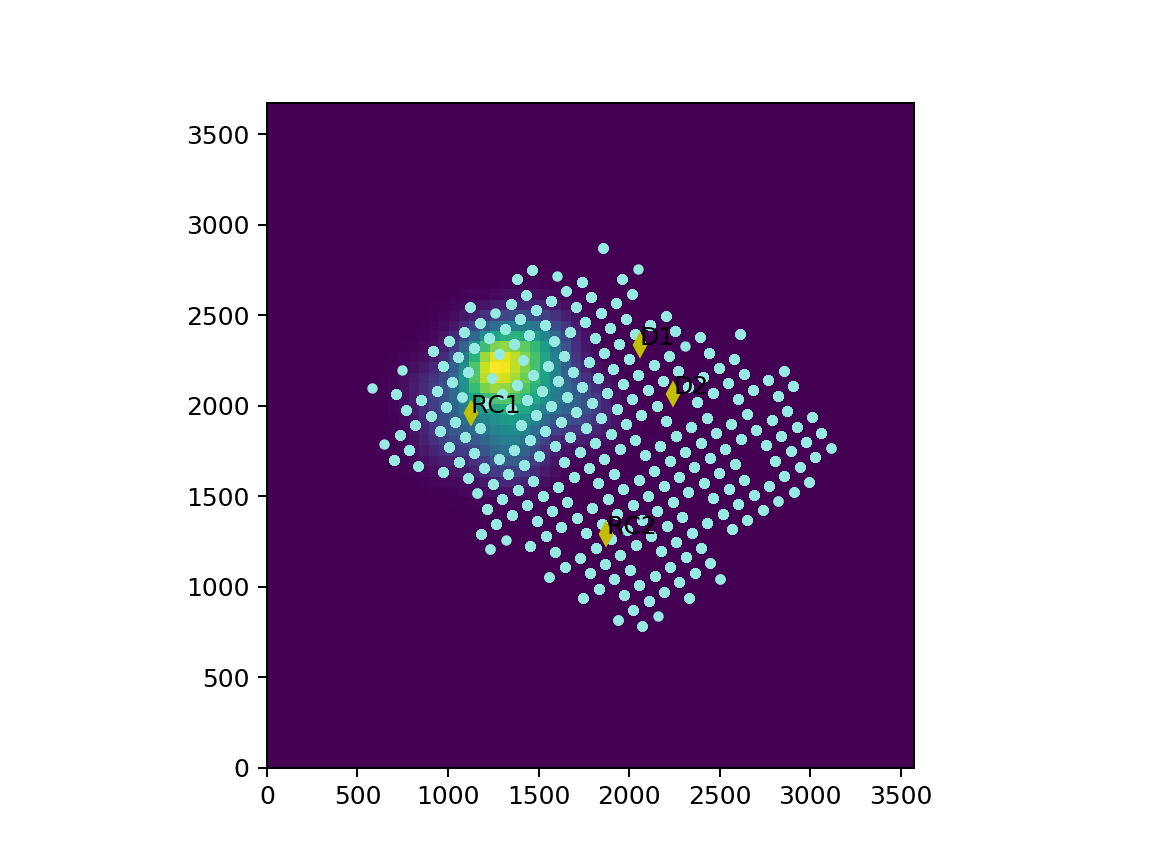

In [89]:
fig, ax = plt.subplots()
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(data.map(lambda p: {'x': p['x'], 'y': p['y']}).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in np.arange(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        name = nombre_antenas[antenna]
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 

#plt.imshow(heatmap, extent=extent, origin='lower', cmap=None)
plt.imshow(gaussian_filter(heatmap, sigma=2, mode='nearest'), extent=extent, origin='lower', cmap=None)